# Crime Rate Analysis Before and During the pandemic in Vancouver

## Introduction

For our project, we will analyze the Geodash crime data provided by the Vancouver Police department to see if there was any noticeable impact of the Covid-19 pandemic on the crime rate in each neighborhood of the city. The Geodash crime data is a database offered by the Vancouver Police to help researchers, media and organizations that want to examine crime and police activity (Vancouver Police Department, 2022). This tool allows us access to datasets that include the type of crime reported to the Vancouver Police and the given report's time, date, and neighborhood. With this information, we can perform analyses to better understand the effect that Covid-19 had on crimes committed throughout the city. Similar studies have already been conducted between American cities that use statistical and data analysis to answer similar questions (Ashby, 2020; Abrams, 2021).

Our project will use the mean, and standard deviation of the crime rate for each neighborhood through different time frames as parameters to understand how each neighborhood changed and is compared to one another. With the mean crime rate for each time frame, we can better compare neighborhoods regarding safety. With the standard deviation, we can see if any particular neighborhood has a broader range of reported crimes per time frame, which can be an indicator of the impact of external factors like the covid 19 pandemic.

## Result

#### Data Preparation
The dataset is obtained from https://geodash.vpd.ca/opendata/# \
Unfortunately, VPD didn't provide their datasets a URL for direct download into JupyterHub, so we first manually downloaded and stored the dataset to GoogleDrive then generated downloadable URL from there. 

In [8]:
install.packages("infer")

Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.0’
(as ‘lib’ is unspecified)

also installing the dependency ‘patchwork’




In [10]:
library(tidyverse)
library(infer)

In [11]:
# Here we read the data from a google drive that holds our datasets and assign a variable for each year.
URL2017 <- "https://drive.google.com/uc?id=11RimvDwqEXhi88RdmiHg6PUGOL8xXMW4&export=download"
URL2018 <- "https://drive.google.com/uc?id=1vA-vnvTlHoXV1q6bu4S_qay37nz7X3UM&export=download"
URL2019 <- "https://drive.google.com/uc?id=1kBSEJl-JCIzqzVmB9PMLZ-C2WM1hH7je&export=download"
URL2020 <- "https://drive.google.com/uc?id=1zaTH_62fMJNYMjWItzjSvrK3nKdK74Zn&export=download"
URL2021 <- "https://drive.google.com/uc?id=1Inz166gXuGusb47PhV6nQMEpxpl4Wh92&export=download"
URL2022 <- "https://drive.google.com/uc?id=1vUUblkLnMKSxb8S0y55Zi3IHjfIZOJ2N&export=download"
cr2017 <- read.csv(URL2017)
cr2018 <- read.csv(URL2018)
cr2019 <- read.csv(URL2019)
cr2020 <- read.csv(URL2020)
cr2021 <- read.csv(URL2021)
cr2022 <- read.csv(URL2022)

In [12]:
# Now we combine the 6 years into one dataframe
cr2017_2022 <- rbind(cr2017,cr2018,cr2019,cr2020,cr2021,cr2022)
head(cr2017_2022)

# We select the TYPE, YEAR, NEIGHBOURHOOD columns for analysis since they are our variables of interest
crime2017_2022 <- cr2017_2022 %>% 
    select(TYPE, YEAR, MONTH, DAY, NEIGHBOURHOOD) 
head(crime2017_2022)

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,Theft of Vehicle,2017,11,29,20,0,29XX SKEENA ST,Renfrew-Collingwood,497919.2,5456148
2,Theft of Vehicle,2017,6,21,21,0,2X JACKSON AVE,Strathcona,493220.8,5459096
3,Theft of Vehicle,2017,9,21,18,0,2X W 14TH AVE,Mount Pleasant,492319.5,5456190
4,Theft of Vehicle,2017,5,9,15,30,2X W PENDER ST,Central Business District,492338.0,5458667
5,Theft of Vehicle,2017,10,9,6,0,2XX ALEXANDER ST,Strathcona,492802.5,5459038
6,Theft of Vehicle,2017,6,13,6,45,2XX CENTRAL ST,Strathcona,492756.6,5457623


,TYPE,YEAR,MONTH,DAY,NEIGHBOURHOOD
,<chr>,<int>,<int>,<int>,<chr>
1,Theft of Vehicle,2017,11,29,Renfrew-Collingwood
2,Theft of Vehicle,2017,6,21,Strathcona
3,Theft of Vehicle,2017,9,21,Mount Pleasant
4,Theft of Vehicle,2017,5,9,Central Business District
5,Theft of Vehicle,2017,10,9,Strathcona
6,Theft of Vehicle,2017,6,13,Strathcona


#### Preliminary Analysis

In [13]:
# Now we create a column named "total" that holds the overall daily total crime incidents for each neighborhood in each year
crime_total <- crime2017_2022 %>%
    group_by(YEAR, MONTH, DAY, NEIGHBOURHOOD) %>%
    filter(NEIGHBOURHOOD != "") %>%
    summarise(total = n(), `.groups` = "drop")
head(crime_total)

YEAR,MONTH,DAY,NEIGHBOURHOOD,total
<int>,<int>,<int>,<chr>,<int>
2017,1,1,Arbutus Ridge,1
2017,1,1,Central Business District,27
2017,1,1,Dunbar-Southlands,1
2017,1,1,Fairview,5
2017,1,1,Grandview-Woodland,7
2017,1,1,Hastings-Sunrise,8


In [14]:
# On the next three cells we will calculate the average, median and standard deviation for different time frames. Namely we
# will go over the daily, monthly and yearly data for the crime incidents to help our analysis

# First we make the analysis based on the daily data
# Here we calculate the daily average crime incidents for each neighborhood in each year
crime_daily_avg <- crime_total %>%
    group_by(YEAR, DAY, NEIGHBOURHOOD) %>%
    summarise(daily_avg = mean(total), `.groups` = "drop")

# Here we calculate the daily median  for crime incidents for each neighborhood in each year
crime_daily_median <- crime_total %>%
    group_by(YEAR, DAY, NEIGHBOURHOOD) %>%
    summarise(daily_median = median(total), `.groups` = "drop")

# Here we calculate the daily standard deviation for crime incidents for each neighborhood in each year
crime_daily_sd <- crime_total %>%
    group_by(YEAR, DAY, NEIGHBOURHOOD) %>%
    summarise(daily_sd = sd(total), `.groups` = "drop")

# We set up the summary statistics by biding it and selecting the relevant data for later analysis
summary_stats_on_daily <- cbind(crime_daily_avg,crime_daily_median,crime_daily_sd) %>%
    select(c(1,2,3,4,8,12))
head(summary_stats_on_daily)

,YEAR,DAY,NEIGHBOURHOOD,daily_avg,daily_median,daily_sd
,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
1,2017,1,Arbutus Ridge,1.444444,1.0,0.8819171
2,2017,1,Central Business District,36.583333,35.5,9.0096749
3,2017,1,Dunbar-Southlands,2.125000,1.5,1.7268882
4,2017,1,Fairview,6.666667,6.0,3.7009417
5,2017,1,Grandview-Woodland,6.583333,6.0,3.0289012
6,2017,1,Hastings-Sunrise,5.000000,5.5,2.3741027


In [15]:
# Now we make the analysis based on the yearly data
# Here we calculate the yearly average crime incidents for each neighborhood
crime_yearly_avg <- crime_total %>%
    group_by(YEAR, NEIGHBOURHOOD) %>%
    summarise(yearly_avg = mean(total), `.groups` = "drop")

# Here we calculate the yearly median for crime incidents for each neighborhood
crime_yearly_median <- crime_total %>%
    group_by(YEAR, NEIGHBOURHOOD) %>%
    summarise(yearly_median = median(total), `.groups` = "drop")

# Here we calculate the yearly standard deviation for crime incidents for each neighborhood
crime_yearly_sd <- crime_total %>%
    group_by(YEAR, NEIGHBOURHOOD) %>%
    summarise(yearly_sd = sd(total), `.groups` = "drop")

# We set up the summary statistics by biding it and selecting the relevant data for later analysis
summary_stats_on_year <- cbind(crime_yearly_avg,crime_yearly_median,crime_yearly_sd) %>%
    select(c(1,2,3,6,9))
head(summary_stats_on_year)

,YEAR,NEIGHBOURHOOD,yearly_avg,yearly_median,yearly_sd
,<int>,<chr>,<dbl>,<dbl>,<dbl>
1,2017,Arbutus Ridge,1.829787,1,1.126965
2,2017,Central Business District,36.673973,37,8.565873
3,2017,Dunbar-Southlands,2.051383,2,1.215528
4,2017,Fairview,5.988950,6,2.813676
5,2017,Grandview-Woodland,6.617080,6,3.196067
6,2017,Hastings-Sunrise,4.056497,4,2.132223


In [16]:
# Now we make the analysis based on the monthly analysis
# Here we calculate the monthly average crime incidents per day for all neighbourhoods
crime_monthly_avg <- crime_total %>%
    group_by(YEAR,MONTH, NEIGHBOURHOOD) %>%
    summarise(monthly_avg = mean(total), `.groups` = "drop")
#head(crime_monthly_avg)

# Here we calculate the monthly median crime incidents per day for all neighbourhoods
crime_monthly_median <- crime_total %>%
    group_by(YEAR,MONTH, NEIGHBOURHOOD) %>%
    summarise(monthly_median = median(total), `.groups` = "drop")
#head(crime_monthly_median)

# Here we calculate the monthly standard deviation crime incidents per day for all neighbourhoods
crime_monthly_sd <- crime_total %>%
    group_by(YEAR,MONTH, NEIGHBOURHOOD) %>%
    summarise(monthly_sd = sd(total), `.groups` = "drop")
#head(crime_monthly_sd)

# We set up the summary statistics by biding it and selecting the relevant data for later analysis
summary_stats_on_month <- cbind(crime_monthly_median,crime_monthly_avg,crime_monthly_sd) %>%
    select(c(1,2,3,4,8,12))
head(summary_stats_on_month)

,YEAR,MONTH,NEIGHBOURHOOD,monthly_median,monthly_avg,monthly_sd
,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>
1,2017,1,Arbutus Ridge,1.0,1.470588,0.8744746
2,2017,1,Central Business District,31.0,30.645161,8.3128350
3,2017,1,Dunbar-Southlands,1.5,2.000000,1.3377121
4,2017,1,Fairview,4.0,4.193548,2.1972612
5,2017,1,Grandview-Woodland,4.0,4.833333,2.7175462
6,2017,1,Hastings-Sunrise,3.0,3.344828,1.8376200


In [17]:
# We check the highest average daily cirme incident rate and the neighbourhood where it happened
daily_highest <- max(crime_daily_avg$daily_avg)
highest_area <- crime_daily_avg$NEIGHBOURHOOD[which.max(crime_daily_avg$daily_avg)]
daily_highest
highest_area

# Now the lowest average daily cirme incident rate and the neighbourhood where it happened
daily_lowest <- min(crime_daily_avg$daily_avg)
lowest_area <- crime_daily_avg$NEIGHBOURHOOD[which.min(crime_daily_avg$daily_avg)]
daily_lowest
lowest_area

[1] 53.33333

[1] "Central Business District"

[1] 1

[1] "Musqueam"

#### Visualization

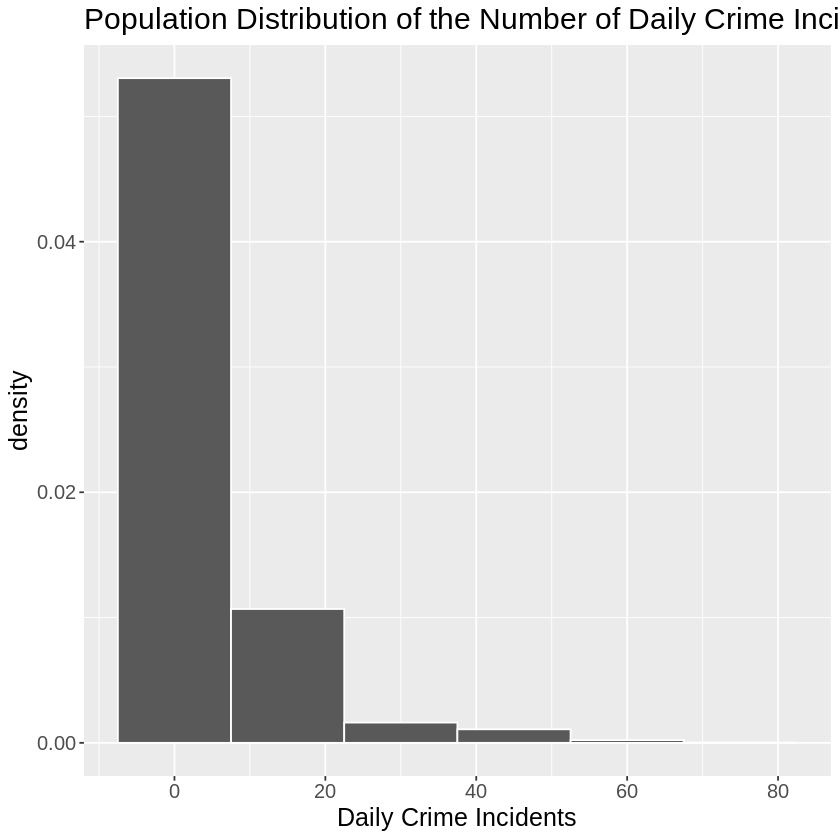

In [18]:
# Here we plot the Population distribution for the daily crime incidents per year
pop_dist <- crime_total %>%
    ggplot() + 
    geom_histogram(aes(x = total, y = ..density..), binwidth = 15, color="white") +
    theme(text = element_text(size = 15))+
    xlab("Daily Crime Incidents") +
    ggtitle("Population Distribution of the Number of Daily Crime Incidents in each year.")
pop_dist

#### Asymptotic 

In [19]:
# Now we will start our asymptotic analysis. First of all we set a seed to ensure reproducibility
set.seed(30)
# Here we get the mean and standard deviation nescessary for the asymptotic analysis based on the "total" column we previously
# created that holds the overall daily total crime incidents for each neighborhood in each year
pop_mu <- mean(crime_total$total)
pop_sd <- sd(crime_total$total)


# Now we create a sample mean for our CLT with the sample size of 500
sample_500 <- crime_total %>%
    rep_sample_n(size = 500, reps = 10000, replace = FALSE) %>%
    group_by(DAY, replicate) %>% 
    summarise(sample_mean = mean(total), `.groups` = "drop")
head(sample_500)

# Here we calculate the normal density and get the shape of the normal distribution to use in the visualization later   
data_normal <- tibble(total=seq(min(crime_total$total), 
                                max(crime_total$total),0.01), 
                                density = dnorm(total, pop_mu, pop_sd))

DAY,replicate,sample_mean
<int>,<int>,<dbl>
1,1,5.666667
1,2,3.583333
1,3,4.166667
1,4,10.500000
1,5,5.125000
1,6,7.533333


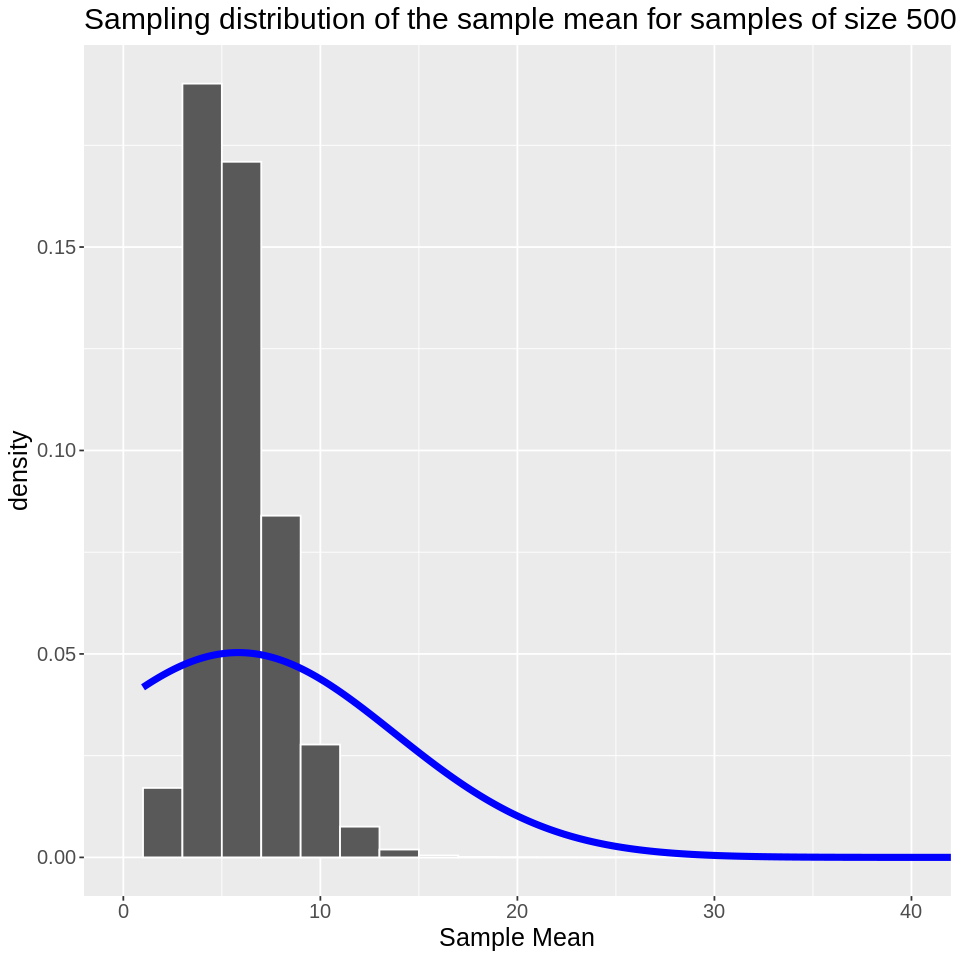

In [20]:
# Now we build the visualization for the sampling distribution of sample means, comparing it to the normal distribution shape
# to help our analysis
options(repr.plot.width = 8, repr.plot.height = 8)
sampling_dist_500 <- sample_500 %>% 
    ggplot() + 
    geom_histogram(aes(x = sample_mean, y = ..density..), binwidth = 2, color="white") +
    theme(text = element_text(size = 15))+
    xlab("Sample Mean") +
    ggtitle("Sampling distribution of the sample mean for samples of size 500 for Crime in Vancouver from 2017-2022.") + 
    geom_line(data = data_normal, aes(total, density), color = "blue", lwd = 2)+
    coord_cartesian(xlim=c(0,40))
sampling_dist_500

#### Bootstrapping

In [22]:
# Now we will make a bootstrapping analysis to compare with our asymptotic analysis to better answer our questions. Firstly we
# once again set a seed to ensure reproducibility
set.seed(31)

# Here we do the Bootstrap with a sample size of 500. But first we will take a sample of our population since we do have the
# total population of reported crimes in Vancouver in our dataset
one_sample <- crime_total %>%
    rep_sample_n(size = 500, reps = 1, replace = FALSE)
boot_500 <- one_sample %>%
    rep_sample_n(size = 500, reps = 10000, replace = TRUE) %>%
    group_by(DAY, replicate) %>% 
    summarise(sample_mean = mean(total), `.groups` = "drop")
head(boot_500)


DAY,replicate,sample_mean
<int>,<int>,<dbl>
1,1,3.187500
1,2,5.764706
1,3,6.214286
1,4,5.000000
1,5,4.692308
1,6,4.421053


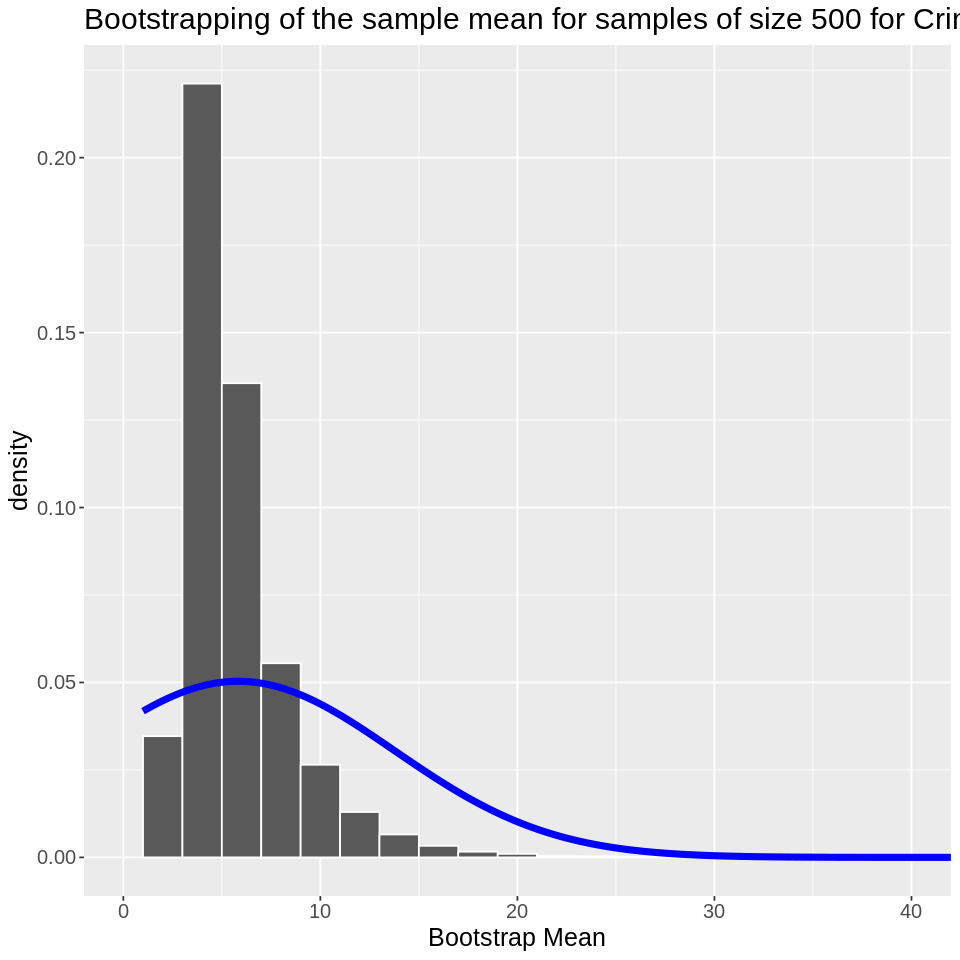

In [23]:
# Here we made the visualization for the bootstrapping of the sample means 
options(repr.plot.width = 8, repr.plot.height = 8)
bootstrap_500 <- boot_500 %>% 
    ggplot() + 
    geom_histogram(aes(x = sample_mean, y = ..density..), binwidth = 2, color="white") +
    theme(text = element_text(size = 15))+
    xlab("Bootstrap Mean") +
    ggtitle("Bootstrapping of the sample mean for samples of size 500 for Crime in Vancouver from 2017-2022.") + 
    geom_line(data = data_normal, aes(total, density), color = "blue", lwd = 2)+
    coord_cartesian(xlim=c(0,40))
bootstrap_500

## Method



  In this project, we thoroughly analyzed the average number of crime incidents across neighborhoods, months and years. There exists a noticeable difference in crime rate across the above variables. Specifically, a sharp decrease in crime rate since the beginning of COVID-19 in 2020 was found. But such findings are rudimentary and speculative in nature, we need more robust evidence to confidently conclude the observed difference in crime rate is meaningful. In order to make the project results trustworthy, we decided to carry out the following: 

1. An independent sample t-test in testing the average amount of crime incidents between year intervals 2017-2019 and 2020-2022 
 <br> $H_0$ : $\mu_{2017-2019}$ - $\mu_{2020-2022}$ = 0;
 <br> $H_1$ : $\mu_{2017-2019}$ - $\mu_{2020-2022}$ > 0;
2. Generate a confidence interval from bootstrapping and sampling distributions for the average crime incidents of 2017-2019 and 2020-2022;
3. Compare the result obtained from bootstrapping and sampling distribution

  In the final report, we expect to first provide robust evidence on whether crime rate has decreased since the start of COVID-19, then obtain a confidence interval for crime rate for the period 2020~2022. Such results would be informative for policy makers for this change in crime rate if later found to be long lasting. In fact, such results could lead to interesting follow up questions such as does the observed long term change in trend in criminal activity related to periods of economic downturn, if so would a reversal in trend be an indicator of economic recovery?


In [92]:
# First we set a seed to ensure reproducibility and do an analysis based on a bootstrapping distribution
set.seed(32)
# Secondly we break the dataset into two different ones, one pre covid years and another one with covid years
pre_covid <- crime_yearly_avg %>%
filter(YEAR == 2017:2019)
during_covid <- crime_yearly_avg %>%
filter(YEAR == 2020:2022)

# Now we make our Boostrapping distribution for pre covid years with sample size of 500
sample_1 <- rep_sample_n(pre_covid, size = 20)
bootstrap_pre_covid_dist <- sample_1 %>% 
rep_sample_n(size = 500, reps = 1000, replace = TRUE) %>%
group_by(replicate) %>%
summarize(stat = mean(yearly_avg))

# And now we get our confidence interval for the bootstrap distribution with a 95% confidence interval
pre_covid_boot_ci <- bootstrap_pre_covid_dist %>%
get_confidence_interval(level = 0.95, type = "percentile")

# Here we repeat the process for the covid years. Firstly make our Boostrapping distribution for covid years with sample size of
# 500
sample_2 <- rep_sample_n(during_covid, size = 20)
bootstrap_during_covid_dist <- sample_2 %>% 
rep_sample_n(size = 500, reps = 1000, replace = TRUE) %>%
group_by(replicate) %>%
summarize(stat = mean(yearly_avg))

# Once again we get the confidence interval of our bootstrap distribution with a 95% confidence interval
during_covid_boot_ci <- bootstrap_during_covid_dist %>%
get_confidence_interval(level = 0.95, type = "percentile")

# Now we get the lower and upper values for each year group and subtract them to get the difference between the two. This way
# we can try to see if there was any difference in the true mean pre and during covid
bootstrap_mean_diff_ci <- tibble(
    lower_ci = pre_covid_boot_ci$lower_ci - during_covid_boot_ci$lower_ci,
    upper_ci = pre_covid_boot_ci$upper_ci - during_covid_boot_ci$upper_ci)
    
bootstrap_mean_diff_ci

lower_ci,upper_ci
<dbl>,<dbl>
1.510691,2.078547


-From the Bootstrapping distribution confidence interval, we are 95% confident that the true mean difference of crime rate between pre-covid and during-covid will fall in the interval [1.510691, 2.078547].

In [93]:
# Now we will do an analysis based on the sampling distribution. First we set a seed to ensure reproducibility
set.seed(33)
# Secondly we break the dataset into two different ones, one pre covid years and another one with covid years
pre_covid <- crime_yearly_avg %>%
filter(YEAR == 2017:2019)
during_covid <- crime_yearly_avg %>%
filter(YEAR == 2020:2022)

#Sampling distribution

# Now we make our Sampling distribution for pre covid years and get the confidence interval for these years
sample_3 <- rep_sample_n(pre_covid, size = 20, reps = 1000)
pre_covid_sampling_ci <- sample_3 %>% 
        group_by(replicate) %>%
        summarize(sample_mean = mean(yearly_avg)) %>%
        get_ci(level = 0.95, type = "percentile")

# Here we make our Sampling distribution for covid years and get the confidence interval for these years
sample_4 <- rep_sample_n(during_covid, size = 20, reps = 1000)
during_covid_sampling_ci <- sample_4 %>%
        summarize(sample_mean = mean(yearly_avg)) %>%
        get_ci(level = 0.95, type = "percentile")

# Now we get the lower and upper values for each year group and subtract them to get the difference between the two. This way
# we can try to see if there was any difference in the true mean pre and during covid
sampling_mean_diff_ci <- tibble(
    lower_ci = pre_covid_sampling_ci$lower_ci - during_covid_sampling_ci$lower_ci,
    upper_ci = pre_covid_sampling_ci$upper_ci - during_covid_sampling_ci$upper_ci)
    
sampling_mean_diff_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.6765738,1.463917


-From the Sampling distribution confidence interval, we are 95% confident that the true mean difference of crime rate between pre-covid and during-covid will fall in the interval [0.6765738, 1.463917].

## Reference
- Abrams, D. S. (2021). COVID and crime: An early empirical look. Journal of Public Economics, Volume 194(2021), 104344. ScienceDirect. https://doi.org/10.1016/j.jpubeco.2020.104344 

- Ashby, M. P. J. (2020). Initial evidence on the relationship between the coronavirus pandemic and crime in the United States. Crime Science, 9(2020), 6. https://doi.org/10.1186/s40163-020-00117-6 

- Vancouver Police Department. (2022, February 15). GeoDASH Crime Data. Vancouver Police Department - GeoDASH. Retrieved March 5, 2022, from https://vpd.ca/crime-statistics/
